In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Dense, Input, Add, BatchNormalization
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import sklearn
#from keras.utils import plot_model
from keras import backend as K
import os
import tensorflow as tf
import tqdm


170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10, 32, 32, 3)


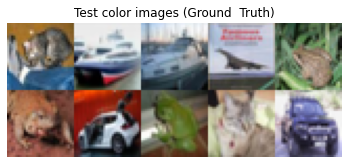

In [3]:
# load the CIFAR10 dataset
#Split the dataset to training (50000 images) and testing (10000 images)
(x_train, y_train), (x_test, _) = cifar10.load_data()

##Printing the shape of the training and testing dataset
print(x_train.shape) # (50000, 32, 32, 3)
print(x_test.shape) # (10000, 32, 32, 3)

# input image dimensions are stored in separate variables
img_rows_count = x_train.shape[1] # Image Height
img_cols_count = x_train.shape[2] # Image width
channels = x_train.shape[3] # Depth/ Channel of Image = 3 (3 since RGB image)

# create saved_images folder
imgs_dir = 'saved_images'

## os.getcwd() - returns the current working directory, os.path.join() - joins the current working directory path to the imgs_dir
save_dir = os.path.join(os.getcwd(), imgs_dir) 

## Create the above directory if it is not created earlier
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)


# display the 1st 100 input color images
imgs = x_test[:10]
print(imgs.shape)
imgs = imgs.reshape((2, 5, img_rows_count, img_cols_count, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs)
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [4]:
## Function to convert RGB image to grayscale image
## All Red Channel pixels is multiplied by 0.299
## All Green Channel pixels is multiplied by 0.299
## All Blue Channel pixels is multiplied by 0.299

def rgbToGray(input_img_list):
  return np.dot(input_img_list[...,:3], [0.299, 0.587, 0.114])

In [ ]:
##########################################################
##################    Approach 1    ######################
##########################################################

'''
AutoEncoder class to create model of AutoEncoder
It has 1 method, autoencoder model learning 3 channels (RGB)
The encoding comes down to 256 bit latent vector in this approach

The Architecture of this approach is as follows

Input Image = 32 x 32 x 1
Conv1 = 3 x 3 filter 64 filters times 2
down1 = Maxpooling
Conv2 = 3 x 3 filter 128 filters times 2
down2 = Maxpooling
Conv3 = 3 x 3 filter 256 filters times 2
down3 = Maxpooling

fc1 = Flatten - 4096 bit vector

latent Feature = 256 bit vector

fc2 = 4096 bit vector

up1 = Upsampling
Conv4 = 3 x 3 filter 256 filters times 2
up2 = Upsampling 
Conv5 = 3 x 3 filter 128 filters times 2
up3 = Upsampling
Conv6 = 3 x 3 filter 64 filters times 2

output = 32 x 32 x 3 -- Color Image

'''

class AutoEncoder :
  def __init__(self, input_image_size):
    print("This is the AutoEncoder Class!!")
    ##input_image_size is a tuple containing the image height, width and channels
    self.img_size = input_image_size 

    ## Latent vector size (hardcoded)
    self.__latent_dimension_size__=256 

    ## Initiating a feature image size to an empty tuple
    self.__feature_image_size__= tuple()
    #print(self.img_size)

    ## Defining the input tensor for encoder model input
    ## Input for a encoder model is a 32 x 32 image of 1 channel (grayscale)
    self.encoder_input = Input(shape = self.img_size)

    ## Defining the input tensor for decoder model input
    ## Input for a decoder model is a latent vector of dimension 256
    self.decoder_input = Input(shape = (self.__latent_dimension_size__,))

    ## Initializing the latest feature vector of AutoEncoder
    self.latent_feature_vector=np.array([])

    ## Initializing the output image to a empty numpy array
    self.output_img=np.array([])
    
  def autoencoder_model(self):
    '''
    A function to create a encoder model of the AutoEncoder class.
    It has multiple convolution layers to extract the features of the image.
    Finally the input image is reduced to a latent feature vector of dimension 256 bits.

    input to the encoder_model is a grayscale image
    output of the encoder_model is a encoder model
    '''

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(self.encoder_input) #output - 32 x 32 x 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2') (conv1) #output - 32 x 32 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #output -  16 x 16 x 64
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1) #output -  16 x 16 x 128
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(conv2) #output -  16 x 16 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #output -  8 x 8 x 128
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2) #output -  8 x 8 x 256
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(conv3) #output - 8 x 8 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #output - 4 x 4 x 256
    
    self.__feature_image_size__ = pool3.shape ##Saving the shape in order to use it in the decoder while converting the latent vector to image
    #print(self.__feature_image_size__)

    ## The image is flattened to a vector shape. i.e, 4 x 4 x 256 image is flattened to 4096 x 1 vector
    fcn_1= Flatten()(pool3) #output - 4096

    #fcn_2=Dense(1024, activation='relu')(fcn_1)
    ## A FCN layer with 256 neurons
    self.latent_feature_vector=Dense(self.__latent_dimension_size__, activation='relu')(fcn_1) ##output - 256 bit vector

    ## Calculating the FCN layer neuron size from the latent feature image to increase the dimension of the vector from 256 to 4096 (4 x 4 x 256)
    input_neuron_size=self.__feature_image_size__[1] * self.__feature_image_size__[2] \
                * self.__feature_image_size__[3]
    #print(input_neuron_size)

    ## FCN layer to increase the dimension from 256 to 4096
    fcn_1=Dense(input_neuron_size) (self.latent_feature_vector)
    latent_feature_image = Reshape((self.__feature_image_size__[1], self.__feature_image_size__[2], \
                                    self.__feature_image_size__[3]))(fcn_1)  #output - 4 x 4 x 256
    
    #Convolution network
    up1 = UpSampling2D((2,2))(conv7) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1')(up1) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2')(conv4)
    up2 = UpSampling2D((2,2))(conv4) #output - 16 x 16 x 256
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1')(up2)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_2')(conv5)
    up3 = UpSampling2D((2,2))(conv5) #32 x 32 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv6_1')(up3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv6_2')(conv6)

    ## Final image with 3 channels and input size and output size matching the input size
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(conv6)

    ## Decoder model with input as a tensor of latent feature vector of 256 but and output as a image of size 32 x 32 x 3
    autoencoder = Model(self.encoder_input, decoded, name = 'autoencoder')
    return autoencoder


In [ ]:
##########################################################
##################    Approach 2    ######################
##########################################################

'''
AutoEncoder class to create model of AutoEncoder
It has 1 method, autoencoder model learning 3 channels (RGB)
The encoding comes down to 256 bit latent vector in this approach
BatchNormalization is added and a U-Net kind of Skip connection is provided between layers

The Architecture of this approach is as follows

Input Image = 32 x 32 x 1
Conv1 = 3 x 3 filter 64 filters times 2
down1 = Maxpooling
Conv2 = 3 x 3 filter 128 filters times 2
down2 = Maxpooling
Conv3 = 3 x 3 filter 256 filters times 2
down3 = Maxpooling

fc1 = Flatten - 4096 bit vector

latent Feature = 256 bit vector

fc2 = 4096 bit vector

up1 = Upsampling
Conv4 = 3 x 3 filter 256 filters times 2
Conv4 + Conv3
up2 = Upsampling 
Conv5 = 3 x 3 filter 128 filters times 2
Conv5 + Conv2
up3 = Upsampling
Conv6 = 3 x 3 filter 64 filters times 2
Conv6 + Conv1

output = 32 x 32 x 3 -- Color Image

'''

class AutoEncoder :
  def __init__(self, input_image_size):
    print("This is the AutoEncoder Class!!")
    ##input_image_size is a tuple containing the image height, width and channels
    self.img_size = input_image_size 

    ## Latent vector size (hardcoded)
    self.__latent_dimension_size__=256 

    ## Initiating a feature image size to an empty tuple
    self.__feature_image_size__= tuple()
    #print(self.img_size)

    ## Defining the input tensor for encoder model input
    ## Input for a encoder model is a 32 x 32 image of 1 channel (grayscale)
    self.encoder_input = Input(shape = self.img_size)

    ## Defining the input tensor for decoder model input
    ## Input for a decoder model is a latent vector of dimension 256
    self.decoder_input = Input(shape = (self.__latent_dimension_size__,))

    ## Initializing the latest feature vector of AutoEncoder
    self.latent_feature_vector=np.array([])

    ## Initializing the output image to a empty numpy array
    self.output_img=np.array([])
    
  def autoencoder_model(self):
    '''
    A function to create a encoder model of the AutoEncoder class.
    It has multiple convolution layers to extract the features of the image.
    Finally the input image is reduced to a latent feature vector of dimension 256 bits.

    input to the encoder_model is a grayscale image
    output of the encoder_model is a encoder model
    '''

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(self.encoder_input) #output - 32 x 32 x 1
    conv1 = Conv2D(64, (3, 3), padding='same', name='conv1_2') (conv1) #output - 32 x 32 x 64
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #output -  16 x 16 x 64
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1) #output -  16 x 16 x 128
    conv2 = Conv2D(128, (3, 3), padding='same', name='conv2_2')(conv2) #output -  16 x 16 x 128
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #output -  8 x 8 x 128
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2) #output -  8 x 8 x 256
    conv3 = Conv2D(256, (3, 3), padding='same', name='conv3_2')(conv3) #output - 8 x 8 x 256
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #output - 4 x 4 x 256
    
    self.__feature_image_size__ = pool3.shape ##Saving the shape in order to use it in the decoder while converting the latent vector to image
    #print(self.__feature_image_size__)

    ## The image is flattened to a vector shape. i.e, 4 x 4 x 256 image is flattened to 4096 x 1 vector
    fcn_1= Flatten()(pool3) #output - 4096

    #fcn_2=Dense(1024, activation='relu')(fcn_1)
    ## A FCN layer with 256 neurons
    self.latent_feature_vector=Dense(self.__latent_dimension_size__, activation='relu')(fcn_1) ##output - 256 bit vector

    ## Calculating the FCN layer neuron size from the latent feature image to increase the dimension of the vector from 256 to 4096 (4 x 4 x 256)
    input_neuron_size=self.__feature_image_size__[1] * self.__feature_image_size__[2] \
                * self.__feature_image_size__[3]
    #print(input_neuron_size)

    ## FCN layer to increase the dimension from 256 to 4096
    fcn_1=Dense(input_neuron_size) (self.latent_feature_vector)
    latent_feature_image = Reshape((self.__feature_image_size__[1], self.__feature_image_size__[2], \
                                    self.__feature_image_size__[3]))(fcn_1)  #output - 4 x 4 x 256
    
    #Convolution network
    up1 = UpSampling2D((2,2))(conv7) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1')(up1) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), padding='same', name='conv4_2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Add()([conv4, conv3])
    up2 = UpSampling2D((2,2))(conv4) #output - 16 x 16 x 256
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1')(up2)
    conv5 = Conv2D(128, (3, 3), padding='same', name='conv5_2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Add()([conv5, conv2])
    up3 = UpSampling2D((2,2))(conv5) #32 x 32 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv6_1')(up3)
    conv6 = Conv2D(64, (3, 3), padding='same', name='conv6_2')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Add()([conv6, conv1])

    ## Final image with 3 channels and input size and output size matching the input size
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(conv6)

    ## Decoder model with input as a tensor of latent feature vector of 256 but and output as a image of size 32 x 32 x 3
    autoencoder = Model(self.encoder_input, decoded, name = 'autoencoder')
    return autoencoder


In [40]:
##########################################################
##################    Approach 2    ######################
##########################################################

'''
AutoEncoder class to create model of AutoEncoder
It has 1 method, autoencoder model learning 3 channels (RGB)
The encoding comes down to 256 bit latent vector in this approach
BatchNormalization is added and a U-Net kind of Skip connection is provided between layers

The Architecture of this approach is as follows

Input Image = 32 x 32 x 1
Conv1 = 3 x 3 filter 64 filters times 2
down1 = Maxpooling
Conv2 = 3 x 3 filter 128 filters times 2
down2 = Maxpooling
Conv3 = 3 x 3 filter 256 filters times 2
down3 = Maxpooling

conv7 = 3 x 3 filter 512 filters times 1

up1 = Upsampling
Conv4 = 3 x 3 filter 256 filters times 2
Conv4 + Conv3
up2 = Upsampling 
Conv5 = 3 x 3 filter 128 filters times 2
Conv5 + Conv2
up3 = Upsampling
Conv6 = 3 x 3 filter 64 filters times 2
Conv6 + Conv1

output = 32 x 32 x 3 -- Color Image

'''

class AutoEncoder :
  def __init__(self, input_image_size):
    print("This is the AutoEncoder Class!!")
    ##input_image_size is a tuple containing the image height, width and channels
    self.img_size = input_image_size 

    ## Latent vector size (hardcoded)
    self.__latent_dimension_size__=256 

    ## Initiating a feature image size to an empty tuple
    self.__feature_image_size__= tuple()
    #print(self.img_size)

    ## Defining the input tensor for encoder model input
    ## Input for a encoder model is a 32 x 32 image of 1 channel (grayscale)
    self.encoder_input = Input(shape = self.img_size)

    ## Defining the input tensor for decoder model input
    ## Input for a decoder model is a latent vector of dimension 256
    self.decoder_input = Input(shape = (self.__latent_dimension_size__,))

    ## Initializing the latest feature vector of AutoEncoder
    self.latent_feature_vector=np.array([])

    ## Initializing the output image to a empty numpy array
    self.output_img=np.array([])
    
  def autoencoder_model(self):
    '''
    A function to create a encoder model of the AutoEncoder class.
    It has multiple convolution layers to extract the features of the image.
    Finally the input image is reduced to a latent feature vector of dimension 256 bits.

    input to the encoder_model is a grayscale image
    output of the encoder_model is a encoder model
    '''

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(self.encoder_input) #output - 32 x 32 x 1
    conv1 = Conv2D(64, (3, 3), padding='same', name='conv1_2') (conv1) #output - 32 x 32 x 64
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #output -  16 x 16 x 64
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1) #output -  16 x 16 x 128
    conv2 = Conv2D(128, (3, 3), padding='same', name='conv2_2')(conv2) #output -  16 x 16 x 128
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #output -  8 x 8 x 128
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2) #output -  8 x 8 x 256
    conv3 = Conv2D(256, (3, 3), padding='same', name='conv3_2')(conv3) #output - 8 x 8 x 256
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #output - 4 x 4 x 256
    #conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv3_1')(pool3) #output -  8 x 8 x 256
    conv7 = Conv2D(512, (3, 3), padding='same', name='conv7_1')(pool3) #output - 8 x 8 x 256
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    #self.__feature_image_size__ = pool3.shape ##Saving the shape in order to use it in the decoder while converting the latent vector to image
    #print(self.__feature_image_size__)

    ## The image is flattened to a vector shape. i.e, 4 x 4 x 256 image is flattened to 4096 x 1 vector
    #fcn_1= Flatten()(pool3) #output - 4096

    #fcn_2=Dense(1024, activation='relu')(fcn_1)
    ## A FCN layer with 256 neurons
    #self.latent_feature_vector=Dense(self.__latent_dimension_size__, activation='relu')(fcn_1) ##output - 256 bit vector

    ## Calculating the FCN layer neuron size from the latent feature image to increase the dimension of the vector from 256 to 4096 (4 x 4 x 256)
    #input_neuron_size=self.__feature_image_size__[1] * self.__feature_image_size__[2] \
     #           * self.__feature_image_size__[3]
    #print(input_neuron_size)

    ## FCN layer to increase the dimension from 256 to 4096
    #fcn_1=Dense(input_neuron_size) (self.latent_feature_vector)
    #latent_feature_image = Reshape((self.__feature_image_size__[1], self.__feature_image_size__[2], \
    #                                self.__feature_image_size__[3]))(fcn_1)  #output - 4 x 4 x 256
    
    #Convolution network
    up1 = UpSampling2D((2,2))(conv7) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1')(up1) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), padding='same', name='conv4_2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Add()([conv4, conv3])
    up2 = UpSampling2D((2,2))(conv4) #output - 16 x 16 x 256
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1')(up2)
    conv5 = Conv2D(128, (3, 3), padding='same', name='conv5_2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Add()([conv5, conv2])
    up3 = UpSampling2D((2,2))(conv5) #32 x 32 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv6_1')(up3)
    conv6 = Conv2D(64, (3, 3), padding='same', name='conv6_2')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Add()([conv6, conv1])

    ## Final image with 3 channels and input size and output size matching the input size
    decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(conv6)
    decoded = tf.concat([self.encoder_input, decoded], axis = -1)

    ## Decoder model with input as a tensor of latent feature vector of 256 but and output as a image of size 32 x 32 x 3
    autoencoder = Model(self.encoder_input, decoded, name = 'autoencoder')
    return autoencoder


In [41]:
##Splitting the training set of 50,000 image samples to training set and validation set
X_train, X_val, _, _ = train_test_split(x_train, y_train, test_size=0.2)

## Converting all the images to grayscale
X_train_gray=rgbToGray(X_train)
X_val_gray=rgbToGray(X_val)
X_test_gray=rgbToGray(x_test)

## Normalizing the pixel values between 0 and 1
X_train_gray=X_train_gray.astype('float32') / 255
X_val_gray=X_val_gray.astype('float32') / 255
X_test_gray=X_test_gray.astype('float32') / 255

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
X_train = X_train.reshape(X_train.shape[0], img_rows_count, img_cols_count, channels)
X_val = X_val.reshape(X_val.shape[0], img_rows_count, img_cols_count, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows_count, img_cols_count, channels)

# reshape images to row x col x channel for CNN input
X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_rows_count, img_cols_count, 1)
X_val_gray = X_val_gray.reshape(X_val_gray.shape[0], img_rows_count, img_cols_count, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_rows_count, img_cols_count, 1)

## Number of iterations the model runs
epochs = 50

## number of images considered per batch to train the model
batch_size = 32

## storing the image shape to pass as input to the encoder model
img_rows_count = X_train_gray.shape[1]
img_cols_count = X_train_gray.shape[2]
input_channels = 1

## Input shape having the shape (32, 32, 1)
input_shape=(img_rows_count, img_cols_count, input_channels)

autoencoder1=AutoEncoder(input_shape)

## Creating a enoder model of the Autoencoder object
autoencoder_model=autoencoder1.autoencoder_model()
## Displaying the summary of the created encoder model
autoencoder_model.summary()

This is the AutoEncoder Class!!
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 64)   640         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 64)   0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_2 (Conv2D)                (None, 16, 16, 128)  73856       max_pooling2d_9[0][0]            
________________________________________________________

In [42]:
## Creating a input tensor having the shape of input image (32, 32, 1)
input_img = Input(shape = input_shape)

## Creating an AutoEncoder model from the encoder and decoder model
## the output of encoder model is used as the input to the decoder model.
autoencoder_model = Model(input_img, autoencoder_model(input_img))

## Compiling the autoencoder model with loss function and optimizer function
#autoencoder_model.compile(loss='mean_absolute_error', optimizer = 'sgd')
autoencoder_model.compile(loss='mean_absolute_error', optimizer = 'sgd')

## Training the autoEncoder model with training sample and validating the model with the validation samples
autoencoder_train = autoencoder_model.fit(x=X_train_gray,y=X_train, validation_data=(X_val_gray, X_val), batch_size=batch_size,epochs=epochs)

## predicting the colored image for the test grayscale image
pred = autoencoder_model.predict(X_test_gray)

Epoch 1/50
1250/1250 [==============================] - 21s 15ms/step - loss: 0.1002 - val_loss: 0.0777
Epoch 2/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0775 - val_loss: 0.0724
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0720 - val_loss: 0.0713
Epoch 4/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0682 - val_loss: 0.0658
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0656 - val_loss: 0.0633
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0635 - val_loss: 0.0617
Epoch 7/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0618 - val_loss: 0.0608
Epoch 8/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0602 - val_loss: 0.0591
Epoch 9/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0591 - val_loss: 0.0581
Epoch 10/50
1250/1250 [==============================] - 19s 16m

x_test image dataset shape
(64, 160, 3)
predicted image dataset shape
(10, 32, 32, 3)


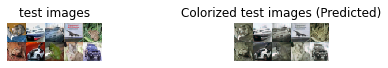

In [43]:
## plotting the autoencoder model predicted image
imgs_test = x_test[:10]

print("x_test image dataset shape")
print(imgs.shape)
#print(imgs)

imgs_test = imgs_test.reshape((2, 5, img_rows_count, img_cols_count, 3))
imgs_test = np.vstack([np.hstack(i) for i in imgs_test])
plt.figure(figsize=(20, 4))
plt.subplot(2, 10, 1)
plt.axis('off')
plt.title('test images')
plt.imshow(imgs_test, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
#plt.show()

imgs_pred = pred[:10]

print("predicted image dataset shape")
print(imgs_pred.shape)
#print(imgs)

imgs_pred = imgs_pred.reshape((2, 5, img_rows_count, img_cols_count, 3))
imgs_pred = np.vstack([np.hstack(i) for i in imgs_pred])
#plt.figure()
plt.subplot(2, 10, 3)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs_pred, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

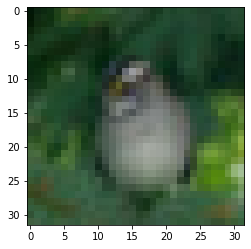

In [44]:
plt.imshow(x_test[900])

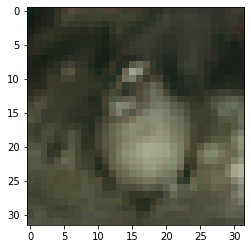

In [45]:
#print(pred[100].shape)
plt.imshow(pred[900])

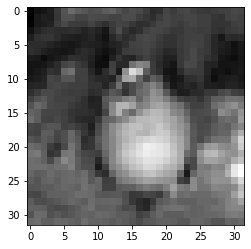

In [46]:
#print(X_test_gray[100].shape)
plt.imshow(X_test_gray[900].reshape((32,32)), cmap='gray')